In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("data/loan_prediction_train.csv")

print(df.head(10))
print(df.describe())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   
5  LP001011   Male     Yes          2      Graduate           Yes   
6  LP001013   Male     Yes          0  Not Graduate            No   
7  LP001014   Male     Yes         3+      Graduate            No   
8  LP001018   Male     Yes          2      Graduate            No   
9  LP001020   Male     Yes          1      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000         

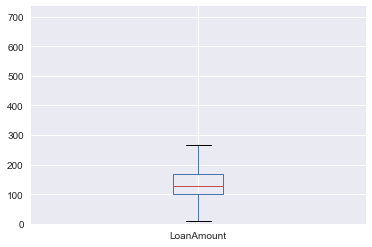

In [3]:
df['LoanAmount'].hist(bins=50)
df.boxplot(column='LoanAmount')

In [4]:
credit = df['Credit_History'].value_counts(ascending=True)
pivot = df.pivot_table(values='Loan_Status', aggfunc=lambda x: x.map({'Y': 1, 'N': 0}).mean(), index='Credit_History')

print(credit)
print('\n')
print(pivot)

0.0     89
1.0    475
Name: Credit_History, dtype: int64


                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


Text(0,0.5,'Loan Status % Approval')

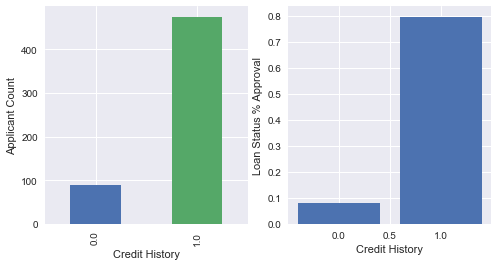

In [5]:
plt.figure(figsize=(8,4))
plt.subplot(121)
credit.plot(kind='bar')
plt.xlabel('Credit History')
plt.ylabel('Applicant Count')
plt.subplot(122)
plt.bar(pivot.index, pivot['Loan_Status'])
plt.xlabel('Credit History')
plt.ylabel('Loan Status % Approval')

In [6]:
#df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
print(df.apply(lambda x: sum(x.isnull()), axis=0))

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


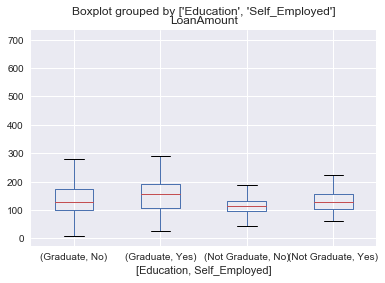

In [7]:
df.boxplot(column='LoanAmount', by=['Education', 'Self_Employed'])

In [8]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [9]:
df['Self_Employed'].fillna('No', inplace=True)

In [10]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed', columns='Education', aggfunc=np.median)
print(table)

Education      Graduate  Not Graduate
Self_Employed                        
No                130.0         113.0
Yes               157.5         130.0


In [11]:
def amount(x):
    return table.loc[x['Self_Employed'], x['Education']]
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(amount, axis=1), inplace=True)
print(sum(df['LoanAmount'].isnull()))

0


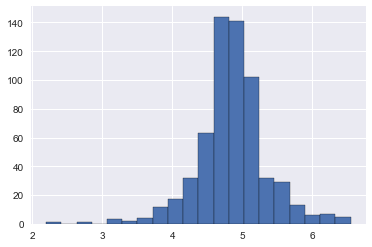

In [12]:
df['LoanAmount_Log'] = np.log(df['LoanAmount'])
df['LoanAmount_Log'].hist(bins=20, edgecolor='k')

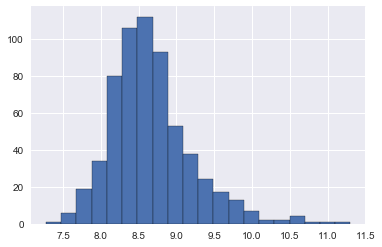

In [13]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_Log'] = np.log(df['TotalIncome'])
df['TotalIncome_Log'].hist(bins=20, edgecolor='k')

In [14]:
print(df['Gender'].value_counts())
print('\n')
print(df['Married'].value_counts())
print('\n')
print(df['Dependents'].value_counts())
print('\n')
print(df['Loan_Amount_Term'].describe())
print(df['Loan_Amount_Term'].value_counts())
print('\n')
print(df['Credit_History'].mean())

Male      489
Female    112
Name: Gender, dtype: int64


Yes    398
No     213
Name: Married, dtype: int64


0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64


0.8421985815602837


In [15]:
df['Gender'].fillna('Male', inplace=True)
df['Married'].fillna('Y', inplace=True)
df['Credit_History'].fillna(1.0, inplace=True)
df['Dependents'].fillna(0, inplace=True)
df['Loan_Amount_Term'].fillna(360, inplace=True)

In [16]:
print(df.apply(lambda x: sum(x.isnull()), axis=0))

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
LoanAmount_Log       0
TotalIncome          0
TotalIncome_Log      0
dtype: int64


In [19]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i].astype(str))
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_Log       float64
TotalIncome          float64
TotalIncome_Log      float64
dtype: object

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [43]:
def classification_model(model, data, predictors, outcome):
    model.fit(data[predictors], data[outcome])
    predictions = model.predict(data[predictors])
    
    accuracy = metrics.accuracy_score(predictions, data[outcome])
    print('Accuracy: %s' % '{0:.3%}'.format(accuracy))
    
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    
    for train, test in kf:
        train_predictors = (data[predictors].iloc[train,:])
        train_target = data[outcome].iloc[train]
        
        model.fit(train_predictors, train_target)
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
        
    print('Cross Validation Score: %s' % '{0:.3%}'.format(np.mean(error)))
    
    model.fit(data[predictors], data[outcome])

In [39]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 80.945%
Cross Validation Score: 80.946%


In [47]:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 80.945%
Cross Validation Score: 78.179%


In [48]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History', 'Gender', 'Married', 'Education']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 80.945%
Cross Validation Score: 80.946%


In [49]:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_Log']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 88.925%
Cross Validation Score: 69.046%


In [50]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'LoanAmount_Log', 'TotalIncome_Log']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 100.000%
Cross Validation Score: 78.502%


In [53]:
feat_importance = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(feat_importance)

Credit_History      0.270276
TotalIncome_Log     0.263007
LoanAmount_Log      0.225615
Dependents          0.055187
Property_Area       0.049327
Loan_Amount_Term    0.041936
Married             0.027697
Gender              0.023825
Education           0.022480
Self_Employed       0.020650
dtype: float64


In [54]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_Log', 'LoanAmount_Log', 'Credit_History', 'Dependents', 'Property_Area']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 82.248%
Cross Validation Score: 80.786%
